# English Data Topic Modeling Using `LDA`

## Modeul Import

In [1]:
# self defined Modules
from myModules.utils.merge.mergeOverPeriod import merge
from myModules.TopicModeling.LDA.ldaModeling import buildDTM, topicWords, visualizeLDA

# General Modules
import pandas as pd
import numpy as np
import pickle
from itertools import product

import warnings
from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

# NLP
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline

## Data Load

In [2]:
DATA_ROOT = './processed-data/'

PERIOD_1 = DATA_ROOT + 'period-1/'
PERIOD_2 = DATA_ROOT + 'period-2/'
PERIOD_3 = DATA_ROOT + 'period-3/'

RESULT_ROOT = './Result/3구간/'

RESULT_1 = RESULT_ROOT + '/1시기/ST/'
RESULT_2 = RESULT_ROOT + '/2시기/ST/'
RESULT_3 = RESULT_ROOT + '/3시기/ST/'

In [3]:
with open(PERIOD_1+"lemmatized-all.pkl", "rb") as f:
    all_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-noun.pkl", "rb") as f:
    noun_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-verb.pkl", "rb") as f:
    verb_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-adjective.pkl", "rb") as f:
    adjective_1 = pickle.load(f)
with open(PERIOD_1+"lemmatized-adverb.pkl", "rb") as f:
    adverb_1 = pickle.load(f)


with open(PERIOD_2+"lemmatized-all.pkl", "rb") as f:
    all_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-noun.pkl", "rb") as f:
    noun_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-verb.pkl", "rb") as f:
    verb_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-adjective.pkl", "rb") as f:
    adjective_2 = pickle.load(f)
with open(PERIOD_2+"lemmatized-adverb.pkl", "rb") as f:
    adverb_2 = pickle.load(f)

with open(PERIOD_3+"lemmatized-all.pkl", "rb") as f:
    all_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-noun.pkl", "rb") as f:
    noun_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-verb.pkl", "rb") as f:
    verb_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-adjective.pkl", "rb") as f:
    adjective_3 = pickle.load(f)
with open(PERIOD_3+"lemmatized-adverb.pkl", "rb") as f:
    adverb_3 = pickle.load(f)

## 4. Topic Modeling

### 4-1. parameter tuning & LDA modeling

- topic num : 가설로 설정한 topic의 갯수
    1. Topic Coherence
        - 주제의 일관성 측정
        - 모델링이 잘 될수록 한 주제 안에는 의미론적으로 유사한 단어가 많이 모여있게 됨.
        - 높을수록 의미론적 일관성이 높다.
        - Coherence가 높아지면 Monotonic 해지는 문제점이 생긴다.
        - coherence가 너무 높아지면 정보의 양이 줄어들고, coherence가 너무 낮으면 정보들의 연관성이 없어져 분석의 의미가 없다.
    2. Perplexity   
        - Coherence가 이 data에서 topic number가 늘어날수록 거의 같이 늘어나는 경향을 보임
        - 따라서 다른 평가기준도 함께 고려해야겠다는 생각에 추가
        - 작아질수록 토픽모델이 문서를 잘 반영한다.

- lda modeling 결과를 시각화해 보았을 때, 10이상으로 넘어가면 할당되지 않는 빈 id들이 발견되었습니다.
    - 따라서 시험할 k값의 범위를 1~15까지 자연수로 설정하였습니다.


In [4]:
NUM_TOPIC_WORDS = 30
PASSES = 30
random_state = 42

In [14]:
class BestLDAPram:
    def __init__(self, data, passes=30, random_state=42):
        self.data = data
        self.passes = passes
        self.random_state = random_state
        self.corpus, self.dictionary = buildDTM(self.data)
    
    def grid_search(self, param_grid, result_save_root='./'):
        grid_search_table = []

        iterator = list(product(param_grid['num_topics'], param_grid['alpha'], param_grid['eta']))

        for num_topic, alpha, eta in tqdm(iterator, desc="LDA Parameter Grid Searching"):
            coherence_value = self.calc_coherence(num_topic=num_topic, alpha=alpha, eta=eta)
            grid_search_table.append([num_topic, alpha, eta, coherence_value])
        
        self.grid_search_table = pd.DataFrame(grid_search_table)
        self.grid_search_table.columns = ['Topics', 'Alpha', 'Eta', 'Coherence']

        self.grid_search_table.to_csv(result_save_root+'lda-param-grid-search.csv', index=False)
    
    def calc_coherence(self, num_topic, alpha, eta):
        model = models.ldamodel.LdaModel(corpus=self.corpus, id2word=self.dictionary, num_topics=num_topic, \
            passes=self.passes, alpha=alpha, eta=eta, random_state=self.random_state)
        
        coherence_model = CoherenceModel(model=model, texts=self.data, dictionary=self.dictionary, coherence='c_v')
        
        return coherence_model.get_coherence()
    
    def load_grid_search_result(self, grid_search_result):
        self.grid_search_table = grid_search_result
    
    def get_best_params(self):
        num_topics = self.grid_search_table.Topics.unique()
        coherences = []
        for ntopic in num_topics:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Topics == ntopic].mean())
        
        idx = np.argmax(coherences)
        best_num_topics = num_topics[idx]

        alphas = self.grid_search_table.Alpha.unique()
        coherences = []
        for alpha in alphas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Alpha == alpha].mean())
        
        idx = np.argmax(coherences)
        best_alpha = alphas[idx]
        
        etas = self.grid_search_table.Eta.unique()
        coherences = []
        for eta in etas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Eta == eta].mean())
        
        idx = np.argmax(coherences)
        best_eta = etas[idx]

        return best_num_topics, best_alpha, best_eta
    
    def plot_coherence_per_topics(self, title='Coherence per Topic Num', root='./'):
        plt.figure()

        num_topics = self.grid_search_table.Topics.unique()
        coherences = []
        for ntopic in num_topics:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Topics == ntopic].mean())

        plt.plot(num_topics, coherences)

        plt.xlabel('Number of Topics')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

    def plot_coherence_per_alpha(self, title='Coherence per alpha', root='./'):
        plt.figure()

        alphas = self.grid_search_table.Alpha.unique()
        coherences = []
        for alpha in alphas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Alpha == alpha].mean())

        plt.plot(alphas, coherences)

        plt.xlabel('Alpha')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()
    
    def plot_coherence_per_eta(self, title='Coherence per eta', root='./'):
        plt.figure()

        etas = self.grid_search_table.Eta.unique()
        coherences = []
        for eta in etas:
            coherences.append(self.grid_search_table.Coherence[self.grid_search_table.Eta == eta].mean())

        plt.plot(etas, coherences)

        plt.xlabel('Eta')
        plt.ylabel('Coherence')

        plt.title(title)
        plt.savefig(root+title+'.png')
        plt.show()

#### Period 1

In [15]:
lda_param = BestLDAPram(data=all_1, passes=PASSES, random_state=random_state)

##### Prameter의 실험 범위를 설정하고 모든 조합에 대해 Coherence를 계산하여 parameter tuning

- 최초 1회만 실행 -> 약 3시간 정도 걸림.
- grid search 결과를 csv 파일로 저장 -> 불러와서 사용하기

In [ ]:
param_grid = {
    'num_topics' : range(2, 11),
    'alpha' : [i * 0.001 for i in range(1, 11)],
    'eta' : [i * 0.01 for i in range(1, 11)]
}

lda_param.grid_search(param_grid=param_grid)

In [16]:
grid_search_table = pd.read_csv('./lda-param-grid-search.csv')

lda_param.load_grid_search_result(grid_search_result=grid_search_table)

In [18]:
NUM_TOPICS, ALPHA, ETA = lda_param.get_best_params()

print(f"best Number of Topics : {NUM_TOPICS}\nbest Alpha : {ALPHA}\nbest Eta : {ETA}")

best Number of Topics : 5
best Alpha : 0.001
best Eta : 0.08


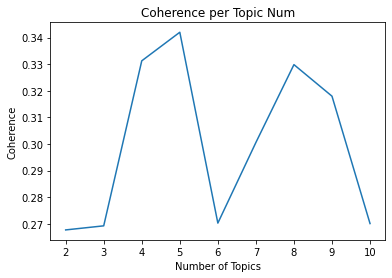

In [19]:
lda_param.plot_coherence_per_topics()

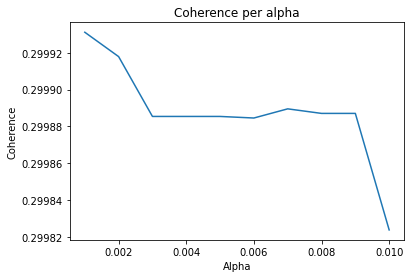

In [20]:
lda_param.plot_coherence_per_alpha()

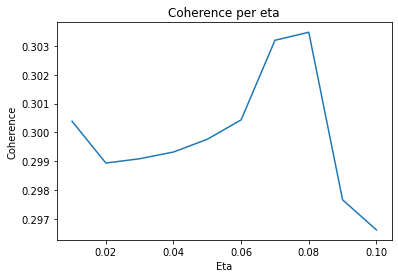

In [21]:
lda_param.plot_coherence_per_eta()

In [22]:
Corp, Dict = buildDTM(all_1)
model = models.ldamodel.LdaModel(corpus=Corp, id2word=Dict, num_topics=NUM_TOPICS, \
            passes=PASSES, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_1+'[Period 1] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107612 -0.099233       1        1  27.473212
2     -0.001070  0.115482       2        1  22.908644
3     -0.085265 -0.175002       3        1  22.557499
0     -0.179314  0.076632       4        1  15.931540
4      0.158038  0.082121       5        1  11.129106, topic_info=            Term        Freq       Total Category  logprob  loglift
2338       negro   55.000000   55.000000  Default  30.0000  30.0000
33      american  234.000000  234.000000  Default  29.0000  29.0000
486       german  142.000000  142.000000  Default  28.0000  28.0000
32       america   81.000000   81.000000  Default  27.0000  27.0000
5567         mvd   39.000000   39.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
503   government   10.307890   86.442933   Topic5  -5.8100   0.0690
2659      russia   10.307786  128.145054   Topic5  -5.8100  -0.3247
1149       still    9.454405   69.766616   Topic5  -5.8965   0.1969
1341       world    9.454389   76.881387   Topic5  -5.8965   0.0998
762          new    9.454886  136.354355   Topic5  -5.8964  -0.4731

[398 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
3030      2  0.888383           acre
3030      5  0.148064           acre
1386      4  0.760739  advertisement
1386      5  0.152148  advertisement
4797      1  0.087495      agreement
...     ...       ...            ...
1350      3  0.036566           york
1350      4  0.804460           york
5054      3  0.988844       zaibatsu
5714      3  0.988843    zavenyaghin
6569      1  1.003649       zimerski

[754 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1, 5])

#### Period 2

In [23]:
lda_param = BestLDAPram(data=all_2, passes=PASSES, random_state=random_state)

##### Prameter의 실험 범위를 설정하고 모든 조합에 대해 Coherence를 계산하여 parameter tuning

- 최초 1회만 실행 -> 약 3시간 정도 걸림.
- grid search 결과를 csv 파일로 저장 -> 불러와서 사용하기

In [24]:
param_grid = {
    'num_topics' : range(2, 11),
    'alpha' : [i * 0.001 for i in range(1, 11)],
    'eta' : [i * 0.01 for i in range(1, 11)]
}

lda_param.grid_search(param_grid=param_grid)

LDA Parameter Grid Searching:   0%|          | 0/900 [00:00<?, ?it/s]

In [25]:
NUM_TOPICS, ALPHA, ETA = lda_param.get_best_params()

print(f"best Number of Topics : {NUM_TOPICS}\nbest Alpha : {ALPHA}\nbest Eta : {ETA}")

best Number of Topics : 5
best Alpha : 0.003
best Eta : 0.04


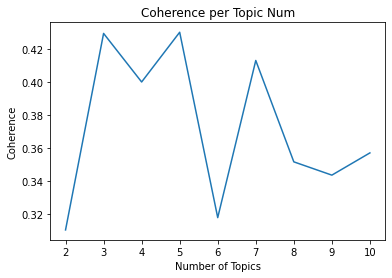

In [26]:
lda_param.plot_coherence_per_topics()

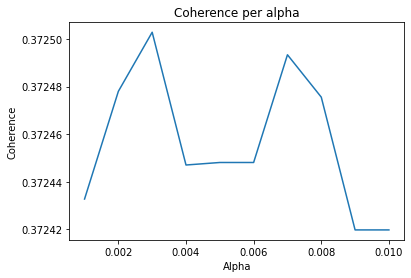

In [27]:
lda_param.plot_coherence_per_alpha()

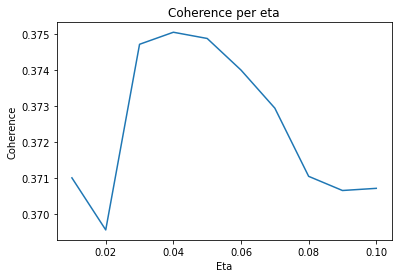

In [28]:
lda_param.plot_coherence_per_eta()

In [29]:
Corp, Dict = buildDTM(all_2)
model = models.ldamodel.LdaModel(corpus=Corp, id2word=Dict, num_topics=NUM_TOPICS, \
            passes=PASSES, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_2+'[Period 2] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.160803  0.141265       1        1  36.659902
4     -0.003388 -0.189998       2        1  25.903073
2     -0.171416 -0.062802       3        1  24.087966
1     -0.127650  0.183240       4        1  13.348885
3      0.141650 -0.071706       5        1   0.000174, topic_info=          Term        Freq       Total Category  logprob  loglift
2994  japanese   97.000000   97.000000  Default  30.0000  30.0000
36    american  137.000000  137.000000  Default  29.0000  29.0000
117    britain   53.000000   53.000000  Default  28.0000  28.0000
2050    russia   62.000000   62.000000  Default  27.0000  27.0000
960     united  164.000000  164.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
349        far    0.000007   50.111594   Topic5  -8.3237  -2.4827
670       plan    0.000007   32.927657   Topic5  -8.3237  -2.0628
548       made    0.000007   48.508016   Topic5  -8.3241  -2.4506
499      japan    0.000007   64.335516   Topic5  -8.3242  -2.7330
596        mr.    0.000007   88.600799   Topic5  -8.3242  -3.0531

[390 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
3         4  0.920979    abolition
9         4  0.920979  accumulated
11        1  0.404432       action
11        2  0.036767       action
11        3  0.514732       action
...     ...       ...          ...
3430      1  1.012693        yalta
1025      1  0.198474         year
1025      2  0.351147         year
1025      3  0.305345         year
1025      4  0.137405         year

[557 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

#### Period 3

In [30]:
lda_param = BestLDAPram(data=all_3, passes=PASSES, random_state=random_state)

##### Prameter의 실험 범위를 설정하고 모든 조합에 대해 Coherence를 계산하여 parameter tuning

- 최초 1회만 실행 -> 약 3시간 정도 걸림.
- grid search 결과를 csv 파일로 저장 -> 불러와서 사용하기

In [32]:
param_grid = {
    'num_topics' : range(2, 11),
    'alpha' : [i * 0.001 for i in range(1, 11)],
    'eta' : [i * 0.01 for i in range(1, 11)]
}

lda_param.grid_search(param_grid=param_grid)

LDA Parameter Grid Searching:   0%|          | 0/900 [00:00<?, ?it/s]

In [38]:
NUM_TOPICS, ALPHA, ETA = lda_param.get_best_params()

print(f"best Number of Topics : {NUM_TOPICS}\nbest Alpha : {ALPHA}\nbest Eta : {ETA}")

best Number of Topics : 8
best Alpha : 0.005
best Eta : 0.01


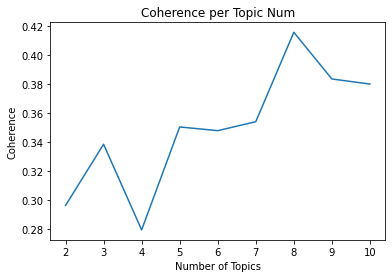

In [39]:
lda_param.plot_coherence_per_topics()

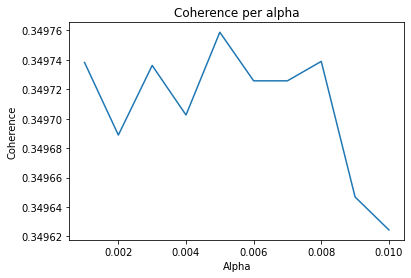

In [40]:
lda_param.plot_coherence_per_alpha()

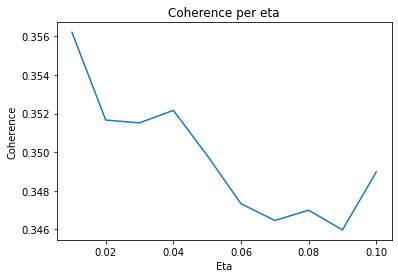

In [41]:
lda_param.plot_coherence_per_eta()

In [42]:
Corp, Dict = buildDTM(all_3)
model = models.ldamodel.LdaModel(corpus=Corp, id2word=Dict, num_topics=NUM_TOPICS, \
            passes=PASSES, alpha=ALPHA, eta=ETA, random_state=random_state)
topicdf = topicWords(model, NUM_TOPIC_WORDS)
topicdf.to_csv(RESULT_3+'[Period 3] topic words.csv', index=False)
data = visualizeLDA(model, Corp, Dict)

data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.095174  0.108135       1        1  41.565441
6     -0.248287  0.074147       2        1  18.858854
2     -0.003730  0.308435       3        1  13.010532
7      0.309245  0.101111       4        1  10.663004
5     -0.211717 -0.181381       5        1   8.895596
0      0.072357 -0.329930       6        1   7.006188
3      0.089337 -0.039556       7        1   0.000192
4      0.087971 -0.040962       8        1   0.000192, topic_info=           Term        Freq       Total Category  logprob  loglift
951         war  219.000000  219.000000  Default  30.0000  30.0000
624       peace  101.000000  101.000000  Default  29.0000  29.0000
781      russia  123.000000  123.000000  Default  28.0000  28.0000
554    military   95.000000   95.000000  Default  27.0000  27.0000
4281     atomic   92.000000   92.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
974        year    0.000009   88.790336   Topic8  -8.6734  -2.8988
1861  secretary    0.000009   82.314748   Topic8  -8.6758  -2.8255
525        made    0.000009   91.058912   Topic8  -8.6761  -2.9267
580         new    0.000009   82.223154   Topic8  -8.6771  -2.8257
226         day    0.000009   82.237326   Topic8  -8.6772  -2.8260

[590 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
5745      3  1.007322          a.m.
980       1  0.067177        access
980       2  0.873302        access
980       5  0.067177        access
10        6  0.970000  accumulating
...     ...       ...           ...
5333      2  0.996262       zealand
2625      2  1.003546         zonal
2626      1  0.042022          zone
2626      2  0.924481          zone
2626      3  0.042022          zone

[937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 3, 8, 6, 1, 4, 5])